In [955]:
!pip install xgboost
!pip install lightgbm


In [956]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Load Dataset

In [957]:
df=pd.read_csv(r'garments_worker_productivity.csv')
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In [958]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

# Data Cleansing

In [959]:
#ubah type data
df['date']=pd.to_datetime(df['date'])
#handling extra space
df['department']=df['department'].str.strip()
#handling kesalahan penulisan
df['department']=df['department'].replace('sweing','sewing')

In [960]:
print('wip',506/1197)

wip 0.4227234753550543


In [961]:
# cek missing value
df.isnull().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

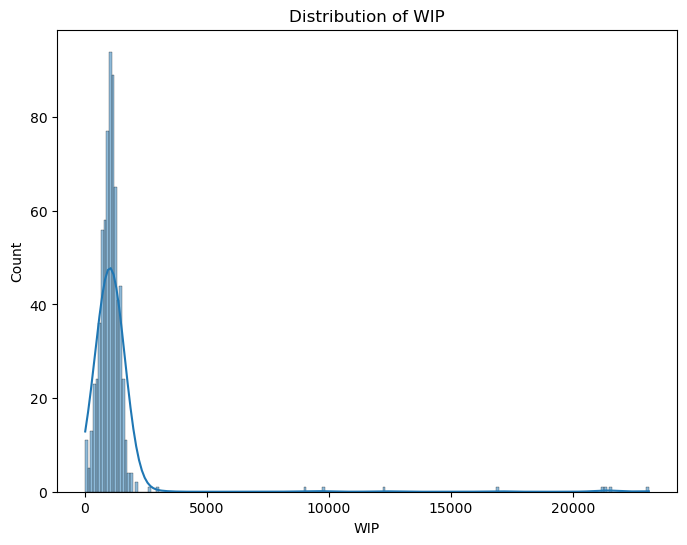

In [962]:
#distribusi wip
plt.figure(figsize=(8,6))
sns.histplot(df['wip'],kde=True)
plt.title('Distribution of WIP')
plt.xlabel('WIP')
plt.show()

In [963]:
#handling missing value
df['wip'].fillna(df['wip'].median(),inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18172\1826739014.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['wip'].fillna(df['wip'].median(),inplace=True)


In [964]:
# Feature baru untuk Target
df['productivity_status']=(df['actual_productivity']>=df['targeted_productivity']).astype(int)

df=df.drop(columns=['actual_productivity','targeted_productivity'])

In [965]:
#cek duplicate
df.duplicated().sum()

0

# Exploratory Data Analays

In [966]:
categoricals=['quarter','department','day']
numericals=['team','smv','wip','over_time','incentive','idle_time','idle_men','no_of_style_change','no_of_workers','productivity_status']
df[numericals].describe()

,team,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_status
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,15.062172,1126.437761,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.730994
std,3.463963,10.943219,1397.653191,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.443628
min,1.000000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,3.000000,3.940000,970.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000
50%,6.000000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,1.000000
75%,9.000000,24.260000,1083.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,1.000000
max,12.000000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.000000


In [967]:
df[categoricals].describe()

,quarter,department,day
count,1197,1197,1197
unique,5,2,6
top,Quarter1,sewing,Wednesday
freq,360,691,208


observasi:
- Paling banyak di Quarter 1, Department sewing, hari Rabu

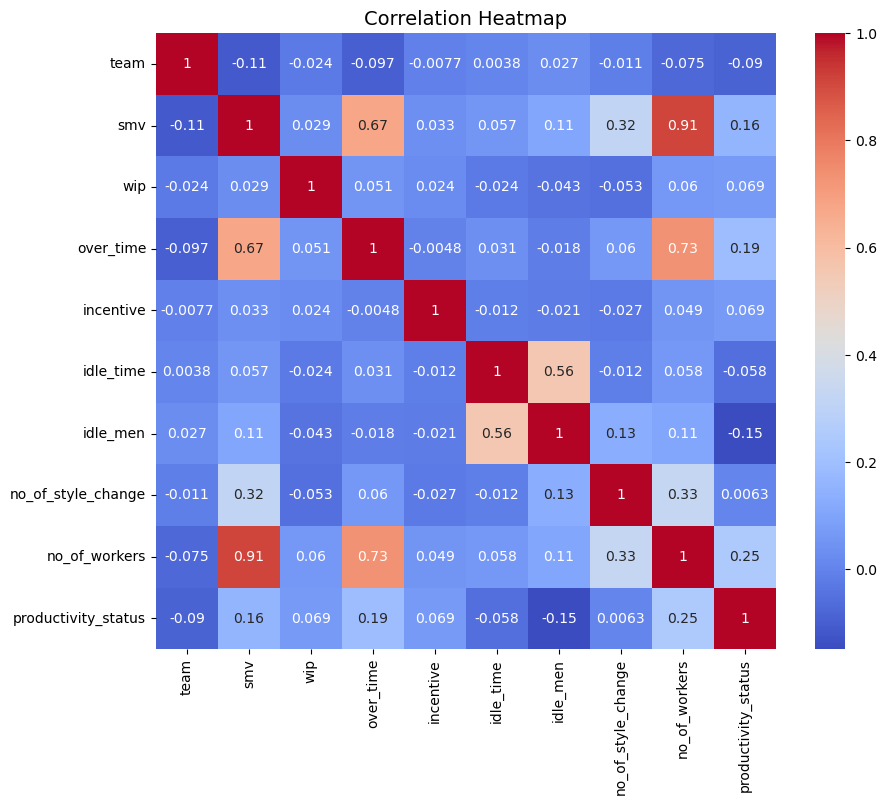

In [968]:
correlation=df[numericals].corr()
# Membuat heatmap
plt.figure(figsize=(10,8))

sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=14)
plt.show()


- no_of_workers
- over_time
- smv
- idle_men (-)

## pengaruh productivity terhadap jumlah pekerja

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18172\2553549175.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  productivity_count=df.groupby(['worker_group','productivity_status']).size().unstack(fill_value=0)


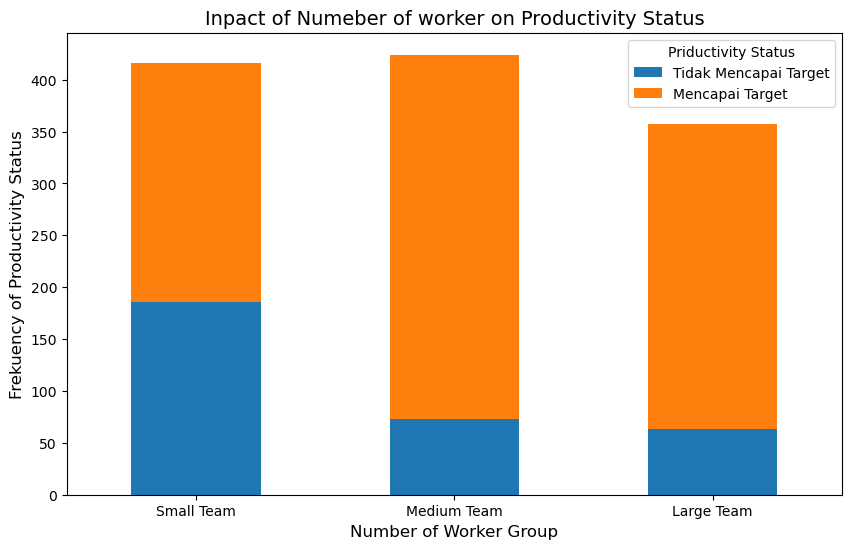

In [969]:
#pengaruh productivity terhadap jumlah pekerja
df['worker_group']=pd.qcut(df['no_of_workers'],q=3,labels=['Small Team','Medium Team','Large Team'])

productivity_count=df.groupby(['worker_group','productivity_status']).size().unstack(fill_value=0)

fig,ax=plt.subplots(figsize=(10,6))
productivity_count.plot(kind='bar',stacked=True,ax=ax)
plt.title('Inpact of Numeber of worker on Productivity Status',fontsize=14)
plt.xlabel('Number of Worker Group',fontsize=12)
plt.ylabel('Frekuency of Productivity Status',fontsize=12)
plt.legend(title='Priductivity Status',labels=['Tidak Mencapai Target','Mencapai Target'])
plt.xticks(rotation=0)
plt.show()

Observasi:
- Kelompok dengan jumlah pekerja medium lebih banyak yang mencapai target
- jika dibandingkan dengan semua grup, kelompok dengan jumlah pekerja lebih banyak paling sedikit yang tidak mencapai target
- Kelompok dengan jumlah pekerja sedikit paling banyak yang tidak mencapai target.

In [970]:
#Uji Chi-Square
from scipy import stats
low_team = df[df['worker_group'] == 'Small Team']['productivity_status']
medium_team = df[df['worker_group'] == 'Medium Team']['productivity_status']
high_team = df[df['worker_group'] == 'Large Team']['productivity_status']

f_stat, p_value=stats.f_oneway(low_team, medium_team, high_team)
print(f'F-statistic: {f_stat}, P-value: {p_value}')

F-statistic: 56.13319269571807, P-value: 5.0191209814913556e-24


Observasi:
- Ada hubungan signifikan anatara grup jumlah pekerja dan produktivitas

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18172\3074138993.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  productivity_counts = df.groupby(['worker_group', 'overtime_group'])['productivity_status'].value_counts(normalize=True).unstack(fill_value=0)


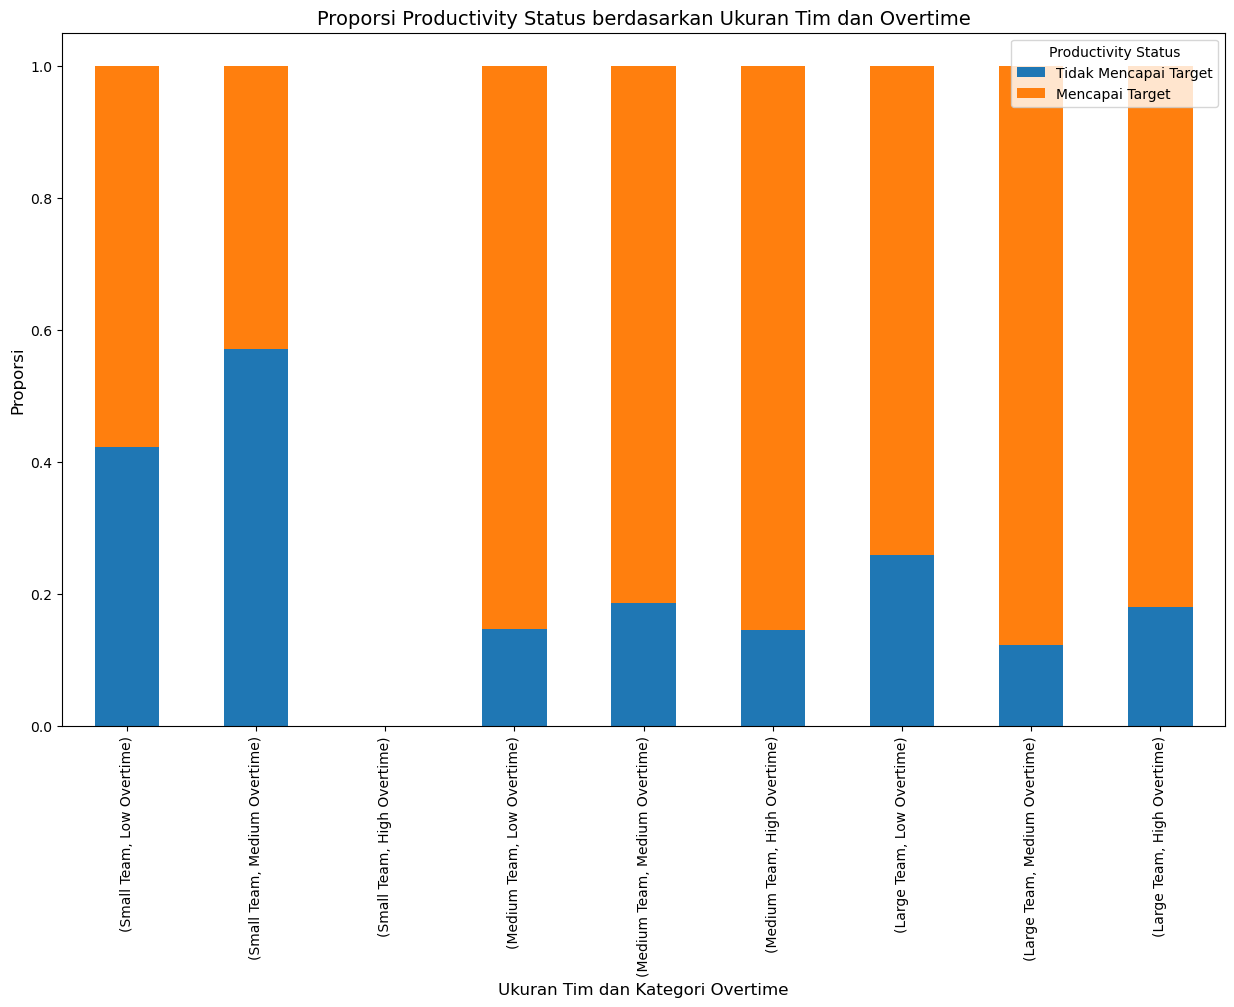

In [971]:
# Mengelompokkan overtime ke dalam tiga kategori
df['overtime_group'] = pd.qcut(df['over_time'], q=3, labels=['Low Overtime', 'Medium Overtime', 'High Overtime'])

productivity_counts = df.groupby(['worker_group', 'overtime_group'])['productivity_status'].value_counts(normalize=True).unstack(fill_value=0)

productivity_counts.plot(kind='bar', stacked=True, figsize=(15, 9))
plt.title('Proporsi Productivity Status berdasarkan Ukuran Tim dan Overtime', fontsize=14)
plt.xlabel('Ukuran Tim dan Kategori Overtime', fontsize=12)
plt.ylabel('Proporsi', fontsize=12)
plt.legend(title='Productivity Status', labels=['Tidak Mencapai Target', 'Mencapai Target'])
plt.xticks(rotation=90)
plt.show()

observasi:
- Produktivitas yang paling tinggi yang tidak mencapai target terjadi pada team yang kecil dengan overtime yang sedang
- team medium lebih bauk dalam mencapai target terutama ketika overtime yang tinggi
- Team besar  tidak menunjukkan produktivitas yang tinggi, bahkan ketika overtime tinggi.

In [972]:
contingency_table = pd.crosstab(index=[df['worker_group'], df['overtime_group']], 
                                 columns=df['productivity_status'])
# Melakukan uji Chi-Square
chi2_stat, p_value,dof, expected= stats.chi2_contingency(contingency_table)

# Tampilkan hasil uji Chi-Square
print(f'Chi2 Statistic: {chi2_stat}')
print(f'P-value: {p_value}')


# Menentukan signifikansi
alpha = 0.05
if p_value < alpha:
    print("Ada hubungan signifikan antara ukuran tim, overtime, dan status produktivitas.")
else:
    print("Tidak ada hubungan signifikan antara ukuran tim, overtime, dan status produktivitas.")

Chi2 Statistic: 112.04739091042953
P-value: 3.451693273448525e-21
Ada hubungan signifikan antara ukuran tim, overtime, dan status produktivitas.


## Pengaruh Overtime terhadap productivity

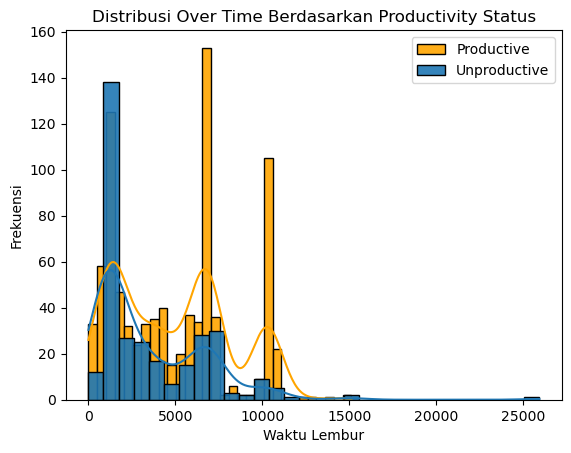

In [973]:
productive=df[df['productivity_status']==1]
unproductive=df[df['productivity_status']==0]
#Histogram untuk tim productive
sns.histplot(productive['over_time'],kde=True, color='orange',label='Productive',bins=30,alpha=0.9)
#histogram untuk tim tdk productive
sns.histplot(unproductive['over_time'],kde=True, label='Unproductive',bins=30,alpha=0.9)

plt.title('Distribusi Over Time Berdasarkan Productivity Status')
plt.xlabel('Waktu Lembur')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()

- Sebagian besar waktu lembur meningkatkan produktivitas terutama pada lembur rendah hingga 5000 menit.
- waktu lembur yang tinggi tidak menjamin peningkatan produktivitas

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18172\1570603216.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  productivity_counts = df.groupby(['overtime_group', 'productivity_status']).size().unstack(fill_value=0)


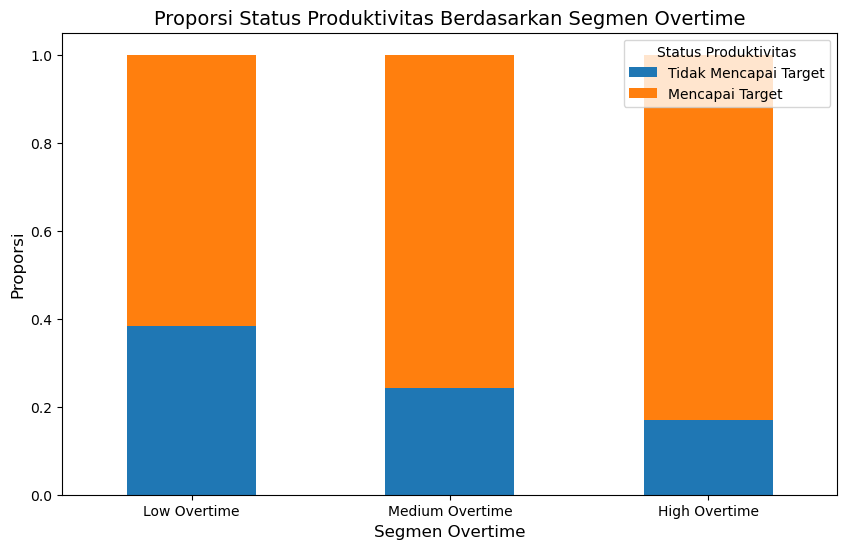

In [974]:
# Menghitung proporsi produktivitas berdasarkan kelompok overtime
productivity_counts = df.groupby(['overtime_group', 'productivity_status']).size().unstack(fill_value=0)

# Hitung proporsi produktivitas
productivity_proportion = productivity_counts.div(productivity_counts.sum(axis=1), axis=0)

# Visualisasi
fig, ax = plt.subplots(figsize=(10, 6))
# Tetapkan warna manual
colors = ['blue', 'orange']  # Warna yang diinginkan
productivity_proportion.plot(kind='bar', stacked=True, ax=ax)
plt.title('Proporsi Status Produktivitas Berdasarkan Segmen Overtime', fontsize=14)
plt.xlabel('Segmen Overtime', fontsize=12)
plt.ylabel('Proporsi', fontsize=12)
plt.legend(title='Status Produktivitas', labels=['Tidak Mencapai Target', 'Mencapai Target'])
plt.xticks(rotation=0)
plt.show()


Observasi:
- Lebih banyak yang tidak mencapai target ketika overtimenya sedikit
- Overtime yang Medium dengan large memiliki perbedaan yang tidak begitu jauh, walaupun overtime yang panjang yang tidak mencapai target paling sedikit

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18172\4179591428.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  productivity_counts = df.groupby(['overtime_group', 'idle_time_group', 'productivity_status']).size().unstack(fill_value=0)


<Figure size 1200x800 with 0 Axes>

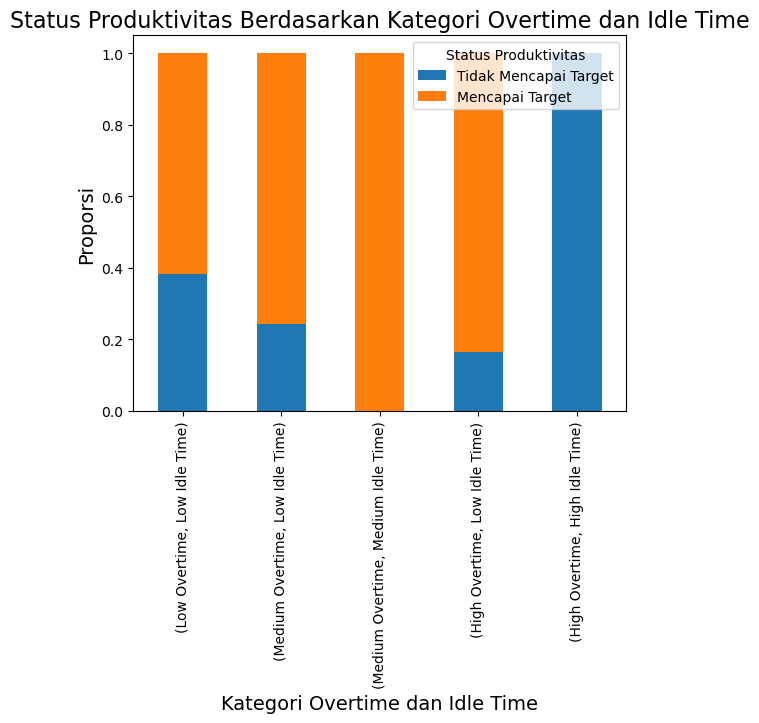

In [975]:
df['idle_time_group'] = pd.cut(df['idle_time'], bins=[-1, 100, 200, float('inf')], 
                                labels=['Low Idle Time', 'Medium Idle Time', 'High Idle Time'])

# Menghitung jumlah produktivitas berdasarkan kombinasi overtime dan idle time
productivity_counts = df.groupby(['overtime_group', 'idle_time_group', 'productivity_status']).size().unstack(fill_value=0)

# Menyaring kategori yang memiliki setidaknya satu data
productivity_counts = productivity_counts[(productivity_counts.sum(axis=1) > 0)]

# Menghitung proporsi produktivitas
productivity_proportion = productivity_counts.div(productivity_counts.sum(axis=1), axis=0)

# Visualisasi menggunakan bar plot
plt.figure(figsize=(12, 8))
productivity_proportion.plot(kind='bar', stacked=True)

# Menambahkan label dan judul
plt.title('Status Produktivitas Berdasarkan Kategori Overtime dan Idle Time', fontsize=16)
plt.xlabel('Kategori Overtime dan Idle Time', fontsize=14)
plt.ylabel('Proporsi', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Status Produktivitas', loc='upper right', labels=['Tidak Mencapai Target', 'Mencapai Target'])

# Menampilkan plot
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

Observasi:
- Idle time yang tinggi secara signifikan menurunkan produktivitas. 

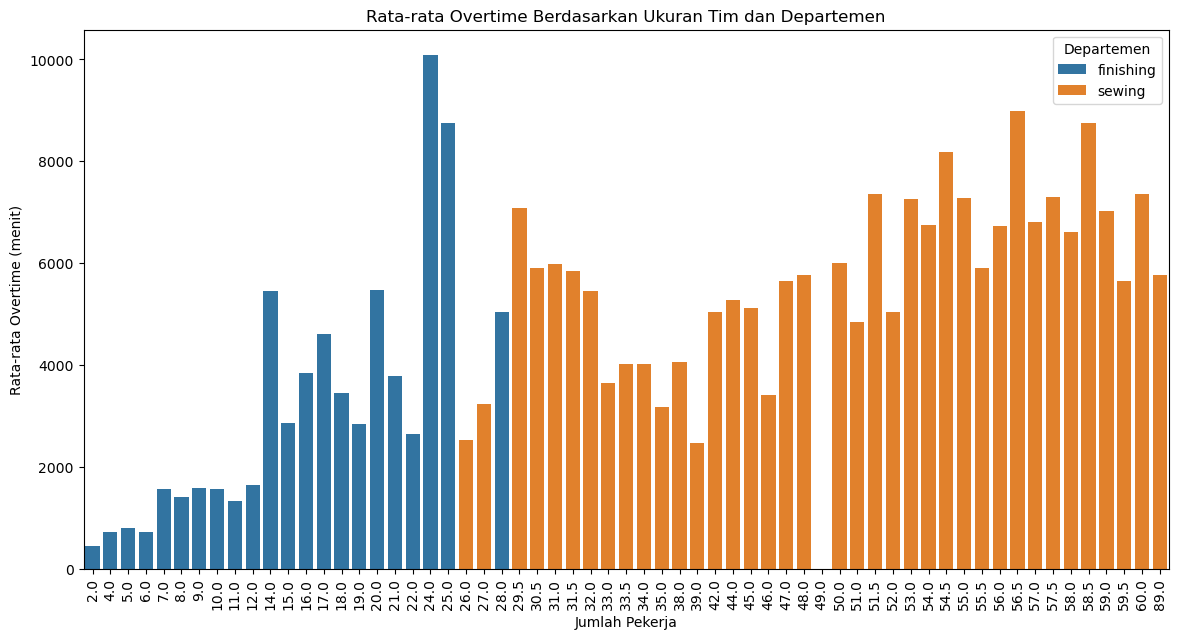

In [976]:
average_overtime = df.groupby(['department', 'no_of_workers'])['over_time'].mean().reset_index()
# Visualisasi menggunakan grafik batang
plt.figure(figsize=(14, 7))
sns.barplot(data=average_overtime, x='no_of_workers', y='over_time', hue='department')
plt.title('Rata-rata Overtime Berdasarkan Ukuran Tim dan Departemen')
plt.xlabel('Jumlah Pekerja')
plt.ylabel('Rata-rata Overtime (menit)')
plt.legend(title='Departemen')
plt.xticks(rotation=90)
plt.show()

-  finishing rata-rata mengalami waktu lembur lebih lama dibanding sewing terutama di ukuran tim 14-25 pekerja.
- overtime meningkat seiring dengan bertambahnya ukuran tim, terutama di departemen sewing.

## Produktivitas terhadap IDle men dan IDLe time

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18172\1043991541.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='productivity_status',y='idle_time',data=df,palette='coolwarm',ci=None)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18172\1043991541.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='productivity_status',y='idle_time',data=df,palette='coolwarm',ci=None)


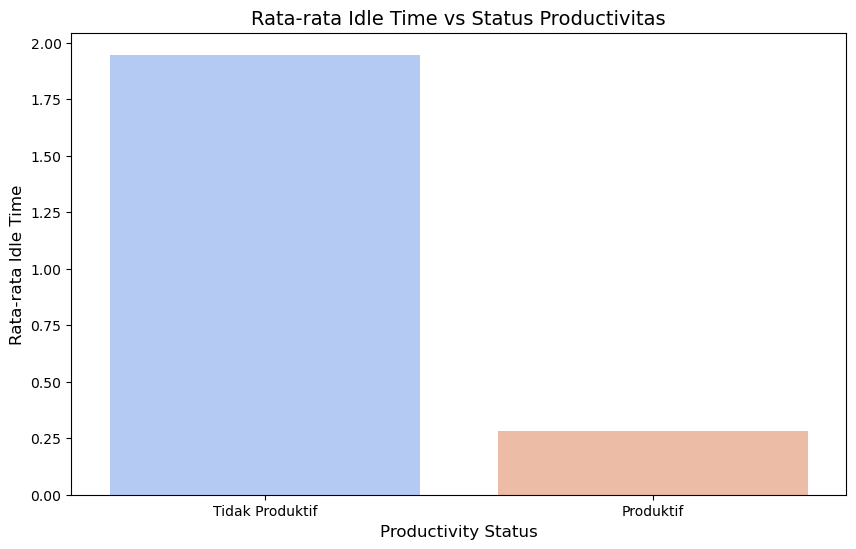

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18172\1043991541.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='productivity_status',y='idle_men',palette='coolwarm',data=df,ci=None)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18172\1043991541.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='productivity_status',y='idle_men',palette='coolwarm',data=df,ci=None)


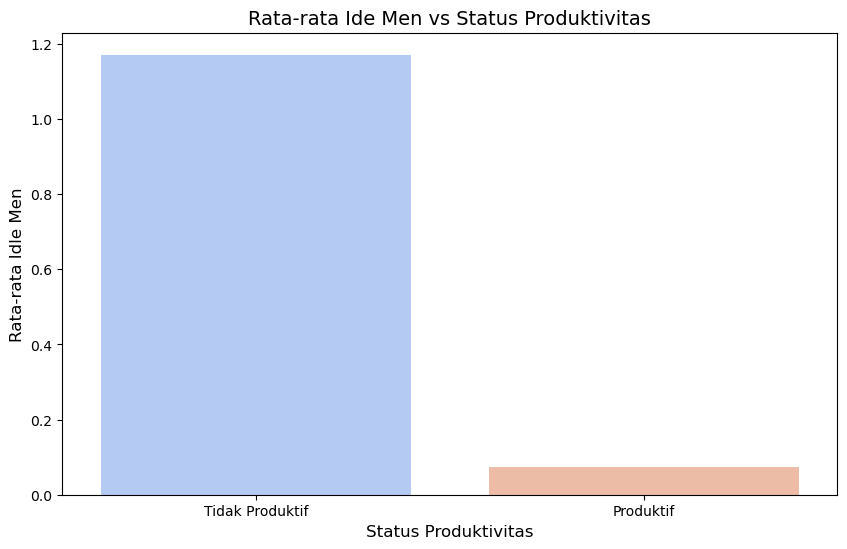

In [977]:
plt.figure(figsize=(10,6))
sns.barplot(x='productivity_status',y='idle_time',data=df,palette='coolwarm',ci=None)
plt.title('Rata-rata Idle Time vs Status Productivitas',fontsize=14)
plt.xlabel('Productivity Status',fontsize=12)
plt.ylabel('Rata-rata Idle Time', fontsize=12)
plt.xticks([0,1],['Tidak Produktif','Produktif'])
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='productivity_status',y='idle_men',palette='coolwarm',data=df,ci=None)
plt.title('Rata-rata Ide Men vs Status Produktivitas',fontsize=14)
plt.xlabel('Status Produktivitas',fontsize=12)
plt.ylabel('Rata-rata Idle Men',fontsize=12)
plt.xticks([0,1],['Tidak Produktif','Produktif'])
plt.show()

Observasi:
- Pekerja yang tidak produktif memiliki rata-rata idle time yang jauh lebih tinggi dibandingkan pekerja yang produktif
-  Idle time yang tinggi secara signifikan mengurangi kemungkinan pekerja mencapai status produktif.
- Idle men yang tinggi secara signifikan mengurangi kemungkinan pekerja mencapai status produktif.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18172\2510823547.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incentive_analysis = df.groupby(['idle_men_group', 'productivity_status'])['incentive'].mean().unstack()


productivity_status          0          1
idle_men_group                           
Low                  20.331169  45.063146
Medium               27.000000  20.000000
High                  8.692308  23.000000


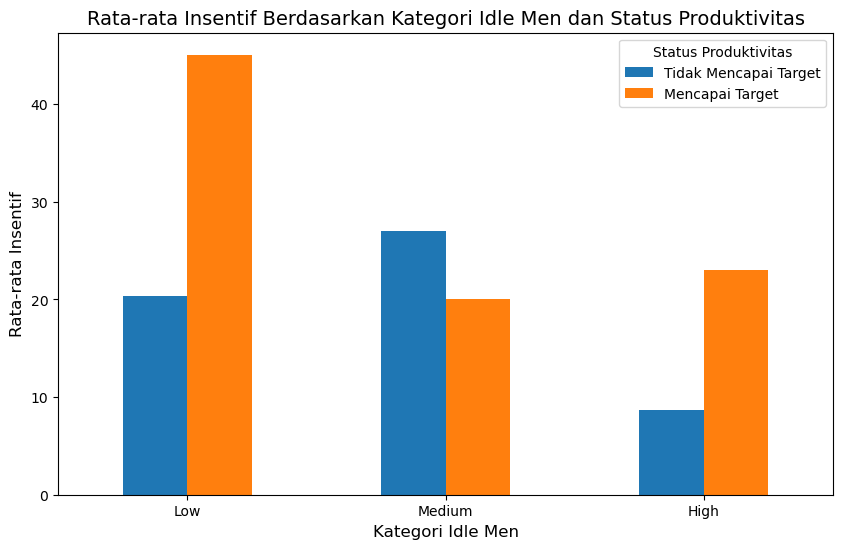

In [978]:
#Membagi Idle men menjadi 3(low, medium, high)
df['idle_men_group'] = pd.cut(df['idle_men'], bins=[-1,0,10,45], labels=['Low', 'Medium', 'High'], include_lowest=True)

# Menghitung rata-rata insentif berdasarkan kategori idle men dan status produktivitas
incentive_analysis = df.groupby(['idle_men_group', 'productivity_status'])['incentive'].mean().unstack()

# Menampilkan hasil analisis
print(incentive_analysis)

# Visualisasi hasil analisis
incentive_analysis.plot(kind='bar', figsize=(10, 6))
plt.title('Rata-rata Insentif Berdasarkan Kategori Idle Men dan Status Produktivitas', fontsize=14)
plt.xlabel('Kategori Idle Men', fontsize=12)
plt.ylabel('Rata-rata Insentif', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Status Produktivitas', labels=['Tidak Mencapai Target', 'Mencapai Target'])
plt.show()

Observasi:

- Idle Men Rendah --> Insentif berperan besar dalam meningkatkan produktivitas, dan semakin tinggi insentif, semakin besar peluang untuk mencapai target.
- Idle Men Sedang-->Insentif yang lebih tinggi tidak selalu berarti produktivitas tercapai, karena idle men sedang tetap menjadi penghambat yang signifikan.
- Idle Men Tinggi-->Insentif masih dapat memotivasi tim untuk mencapai produktivitas meskipun idle men tinggi, namun dampaknya terbatas dan insentif saja tidak cukup untuk mengatasi idle men yang tinggi.

# Outlier

In [979]:
#check outlier
outlier_count={}
for column in numericals:
  q1=df[column].quantile(0.25)
  q3=df[column].quantile(0.75)
  iqr=q3-q1
  lower_bound=q1-1.5*iqr
  upper_bound=q3+1.5*iqr
  outlier=df[(df[column]<lower_bound)|(df[column]>upper_bound)]
  outlier_count[column] = outlier.shape[0]

for column, count in outlier_count.items():
  print(f'jumlah otlier di kolom {column}:{count}')

jumlah otlier di kolom team:0
jumlah otlier di kolom smv:0
jumlah otlier di kolom wip:358
jumlah otlier di kolom over_time:1
jumlah otlier di kolom incentive:11
jumlah otlier di kolom idle_time:18
jumlah otlier di kolom idle_men:18
jumlah otlier di kolom no_of_style_change:147
jumlah otlier di kolom no_of_workers:0
jumlah otlier di kolom productivity_status:0


In [980]:
#Handling outlier
df['wip']=np.log1p(df['wip'])
df['over_time']=np.log1p(df['over_time'])
df['incentive']=np.log1p(df['incentive'])
df['idle_time']=np.log1p(df['idle_time'])
df['idle_men']=np.log1p(df['idle_men'])
df['no_of_style_change']=np.log1p(df['no_of_style_change'])

# Feature Engineering

In [981]:
df=df.drop(columns=['date','idle_time_group','overtime_group','idle_men_group','no_of_workers'])

## Encoding

In [982]:
from sklearn.preprocessing import OrdinalEncoder
for col in categoricals:
  df[col]=df[col].astype(str)
# One-Hot Encoding untuk department dan day
df = pd.get_dummies(df, columns=['department', 'day'], drop_first=True, dtype=int)
# Ordinal Encoding untuk quarter
ordinal_encoder = OrdinalEncoder(categories=[['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5']])
df['quarter_encoded'] = ordinal_encoder.fit_transform(df[['quarter']])
#Ordinal encoding untuk woker dan idle men
ordinal_encoder= OrdinalEncoder(categories=[['Small Team','Medium Team','Large Team']])
df['worker_category_encoded']=ordinal_encoder.fit_transform(df[['worker_group']])

df.drop(['quarter','worker_group'],axis=1,inplace=True)

In [983]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   team                     1197 non-null   int64  
 1   smv                      1197 non-null   float64
 2   wip                      1197 non-null   float64
 3   over_time                1197 non-null   float64
 4   incentive                1197 non-null   float64
 5   idle_time                1197 non-null   float64
 6   idle_men                 1197 non-null   float64
 7   no_of_style_change       1197 non-null   float64
 8   productivity_status      1197 non-null   int32  
 9   department_sewing        1197 non-null   int32  
 10  day_Saturday             1197 non-null   int32  
 11  day_Sunday               1197 non-null   int32  
 12  day_Thursday             1197 non-null   int32  
 13  day_Tuesday              1197 non-null   int32  
 14  day_Wednesday           

# Modeling

## Split Data

In [984]:
from sklearn.model_selection import train_test_split
feature=df.drop(columns='productivity_status')
target=df[['productivity_status']]

feature_train, feature_test,target_train, target_test=train_test_split(feature, target, test_size=0.2, random_state=42)

In [985]:
# Pastikan hanya data numerik yang digunakan untuk VIF
feature_train_numeric = feature_train.select_dtypes(include=['int64', 'float64'])

In [986]:
#define the estimator
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X=add_constant(feature_train_numeric)
vif_df= pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])],index= X.columns).reset_index()
vif_df.columns=['feature','vif_score']
vif_df= vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,team,1.088195
2,smv,4.220828
3,wip,1.086675
4,over_time,1.399026
5,incentive,2.255733
6,idle_time,3.937422
7,idle_men,4.151828
8,no_of_style_change,1.331412
9,quarter_encoded,1.050331
10,worker_category_encoded,4.157816


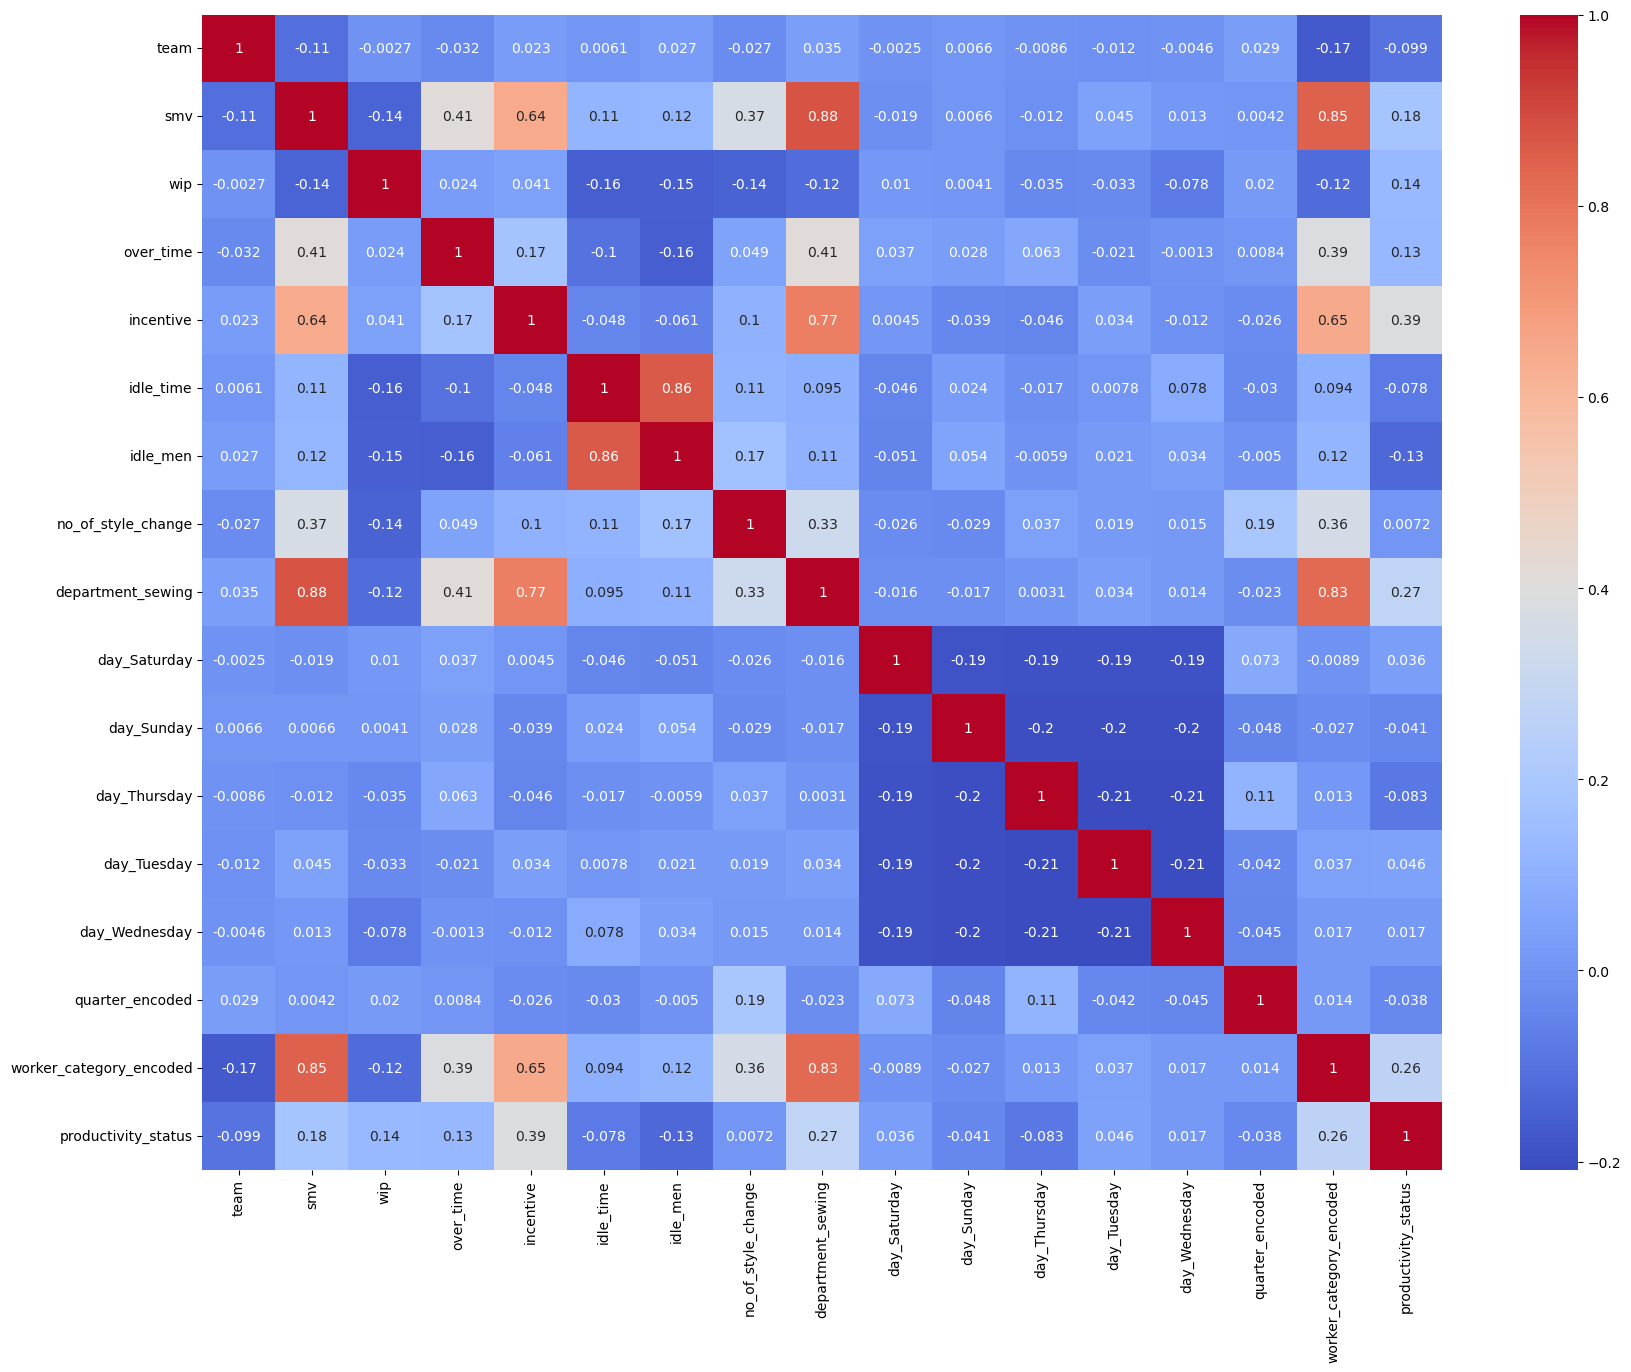

In [987]:
#heatmap correlation
productivity_train=pd.concat([feature_train,target_train],axis=1)
corr=productivity_train.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr,annot=True, cmap='coolwarm')
plt.show()

High Correlation need to drop:

- smv dan department sewing korelasi 0.88
- smv dan worker_category_encoded korelasi 0.85
- idle men dan idle time: 0.86
- department sewing dan worker_category_encoded korelasi 0.88

In [988]:
feature_train=feature_train.drop(columns=['smv','idle_men'])
feature_test=feature_test.drop(columns=['smv','idle_men'])

In [989]:
#feature scalling
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
# Scale the numerical features only on the training data
numerical_features= feature_train.select_dtypes(include=['int64', 'float64']).columns

#fit the scalaar on the training
feature_train[numerical_features] = scaler.fit_transform(feature_train[numerical_features])
# Apply the same scaler to the test data (use transform, not fit_transform)
feature_test[numerical_features] = scaler.transform(feature_test[numerical_features])

In [990]:
#Membangun model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
models={
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier()
}

In [991]:
# Evaluasi model
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


def evaluate_models(feature_train, target_train, feature_test, target_test, use_smote=False):
  results = {}
  if use_smote:
    smote=SMOTE(random_state=42)
    feature_train,target_train=smote.fit_resample(feature_train,target_train)

  for model_name, model in models.items():
    print(f'Training {model_name}...')
    model.fit(feature_train,target_train.values.ravel())
    y_pred=model.predict(feature_test)

    f1 = f1_score(target_test, y_pred, average='weighted')
    print(f"F1 Score of {model_name}: {f1:.4f}")
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(target_test, y_pred))
    results[model_name]=f1


  return results

## SMOTE

In [992]:
# Evaluate models without SMOTE
print("Evaluating models without SMOTE:")
results_without_smote = evaluate_models(feature_train, target_train, feature_test, target_test, use_smote=False)

Evaluating models without SMOTE:
Training Logistic Regression...
F1 Score of Logistic Regression: 0.7081
Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.56      0.22      0.32        63
           1       0.77      0.94      0.85       177

    accuracy                           0.75       240
   macro avg       0.67      0.58      0.58       240
weighted avg       0.72      0.75      0.71       240

Training Random Forest...
F1 Score of Random Forest: 0.7547
Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.57      0.43      0.49        63
           1       0.81      0.89      0.85       177

    accuracy                           0.77       240
   macro avg       0.69      0.66      0.67       240
weighted avg       0.75      0.77      0.75       240

Training Decision Tree...
F1 Score of Decision Tree: 0.7595
Classification Report for Decis

c:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score of XGBoost: 0.7307
Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.50      0.43      0.46        63
           1       0.81      0.85      0.83       177

    accuracy                           0.74       240
   macro avg       0.65      0.64      0.64       240
weighted avg       0.73      0.74      0.73       240

Training LightGBM...
[LightGBM] [Info] Number of positive: 698, number of negative: 259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 394
[LightGBM] [Info] Number of data points in the train set: 957, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.729363 -> initscore=0.991391
[LightGBM] [Info] Start training from score 0.991391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

## Without SMOTE

In [993]:
# Evaluate models with SMOTE
print("\nEvaluating models with SMOTE:")
results_with_smote = evaluate_models(feature_train, target_train, feature_test, target_test, use_smote=True)


Evaluating models with SMOTE:
Training Logistic Regression...
F1 Score of Logistic Regression: 0.7396
Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.48      0.75      0.59        63
           1       0.89      0.72      0.79       177

    accuracy                           0.73       240
   macro avg       0.69      0.73      0.69       240
weighted avg       0.78      0.72      0.74       240

Training Random Forest...
F1 Score of Random Forest: 0.7500
Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.51      0.57      0.54        63
           1       0.84      0.81      0.82       177

    accuracy                           0.75       240
   macro avg       0.68      0.69      0.68       240
weighted avg       0.76      0.75      0.75       240

Training Decision Tree...
F1 Score of Decision Tree: 0.7167
Classification Report for Decisio

c:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score of XGBoost: 0.7535
Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.52      0.57      0.55        63
           1       0.84      0.81      0.83       177

    accuracy                           0.75       240
   macro avg       0.68      0.69      0.69       240
weighted avg       0.76      0.75      0.75       240

Training LightGBM...
[LightGBM] [Info] Number of positive: 698, number of negative: 698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
F1 Score of LightGBM: 0.7725
Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.56      0.59 

In [994]:
# Compare model performance
print("\nModel Comparison without SMOTE:")
for model_name, f1 in results_without_smote.items():
    print(f"{model_name}: {f1:.4f}")

print("\nModel Comparison with SMOTE:")
for model_name, f1 in results_with_smote.items():
    print(f"{model_name}: {f1:.4f}")


Model Comparison without SMOTE:
Logistic Regression: 0.7081
Random Forest: 0.7547
Decision Tree: 0.7595
Gradient Boosting: 0.7598
Support Vector Machine: 0.7146
K-Nearest Neighbors: 0.7465
XGBoost: 0.7307
LightGBM: 0.7323

Model Comparison with SMOTE:
Logistic Regression: 0.7396
Random Forest: 0.7500
Decision Tree: 0.7167
Gradient Boosting: 0.7596
Support Vector Machine: 0.7466
K-Nearest Neighbors: 0.7164
XGBoost: 0.7535
LightGBM: 0.7725


In [995]:
# Select the best model based on F1 Score for further tuning
best_model_name_without_smote = max(results_without_smote, key=results_without_smote.get)
best_model_name_with_smote = max(results_with_smote, key=results_with_smote.get)

print(f"\nBest model without SMOTE: {best_model_name_without_smote} with F1 Score of {results_without_smote[best_model_name_without_smote]:.4f}")
print(f"Best model with SMOTE: {best_model_name_with_smote} with F1 Score of {results_with_smote[best_model_name_with_smote]:.4f}")



Best model without SMOTE: Gradient Boosting with F1 Score of 0.7598
Best model with SMOTE: LightGBM with F1 Score of 0.7725


## Hyper Parameter Tuning

In [996]:
from sklearn.model_selection import GridSearchCV
# Hyperparameter tuning on the best-performing model
LGBM_SMOTE = best_model_name_with_smote  # Ganti jika ingin menggunakan model tanpa SMOTE
best_model = models[LGBM_SMOTE]

if LGBM_SMOTE == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid,
                               scoring='f1_weighted', cv=5, verbose=2, n_jobs=-1)

elif LGBM_SMOTE == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
    grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid,
                               scoring='f1_weighted', cv=5, verbose=2, n_jobs=-1)

elif LGBM_SMOTE == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [100, 200]
    }
    grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid,
                               scoring='f1_weighted', cv=5, verbose=2, n_jobs=-1)

elif LGBM_SMOTE == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid,
                               scoring='f1_weighted', cv=5, verbose=2, n_jobs=-1)

elif LGBM_SMOTE == 'K-Nearest Neighbors':
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid,
                               scoring='f1_weighted', cv=5, verbose=2, n_jobs=-1)

elif LGBM_SMOTE == 'Decision Tree':
    param_grid = {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid,
                               scoring='f1_weighted', cv=5, verbose=2, n_jobs=-1)

elif LGBM_SMOTE == 'Support Vector Machine':
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
    grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid,
                               scoring='f1_weighted', cv=5, verbose=2, n_jobs=-1)

elif LGBM_SMOTE == 'LightGBM':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid,
                               scoring='f1_weighted', cv=5, verbose=2, n_jobs=-1)


# Fit the model with the best parameters
grid_search.fit(feature_train, target_train.values.ravel())

# Show best parameters and score
print(f"Best model: {grid_search.best_estimator_}")
print(f"Best score: {grid_search.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 698, number of negative: 259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 394
[LightGBM] [Info] Number of data points in the train set: 957, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.729363 -> initscore=0.991391
[LightGBM] [Info] Start training from score 0.991391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [997]:
# Cross-validation scores to ensure stability
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(grid_search.best_estimator_, feature_train, target_train.values.ravel(), cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")

[LightGBM] [Info] Number of positive: 558, number of negative: 207
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 765, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.729412 -> initscore=0.991640
[LightGBM] [Info] Start training from score 0.991640
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [998]:
# Predictions on test data
y_pred = grid_search.best_estimator_.predict(feature_test)

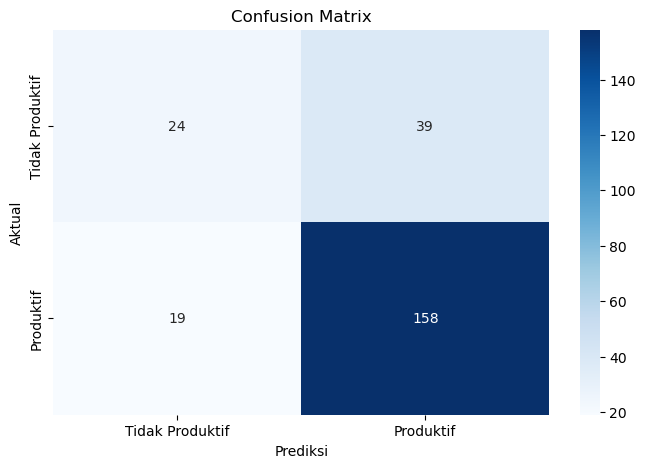

In [999]:

# Confusion matrix
conf_matrix = confusion_matrix(target_test, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tidak Produktif', 'Produktif'], 
            yticklabels=['Tidak Produktif', 'Produktif'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance

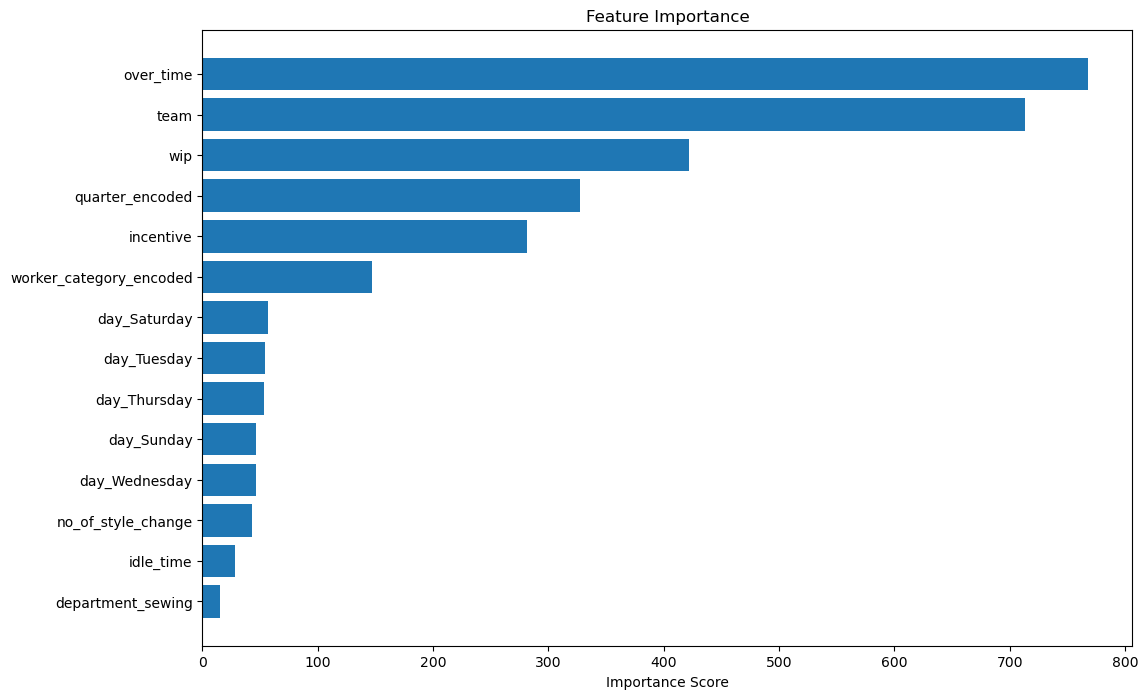

In [1000]:
feature_importances = best_model.feature_importances_
feature_names = feature_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize Feature Importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Reverse y-axis to show most important features at the top
plt.show()